In [1]:
# For example, here's several helpful packages to load in 
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn import model_selection
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import warnings
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:
warnings.simplefilter("ignore")

#Setting dataframe max limit of columns in output to 5
pd.set_option('display.max_columns', 5)

In [4]:
#Importing data and displaying first 10 records
data = pd.read_csv('amazon_alexa.tsv',delimiter='\t',encoding='utf-8')
print(data.head(10))

   rating       date             variation  \
0       5  31-Jul-18      Charcoal Fabric    
1       5  31-Jul-18      Charcoal Fabric    
2       4  31-Jul-18        Walnut Finish    
3       5  31-Jul-18      Charcoal Fabric    
4       5  31-Jul-18      Charcoal Fabric    
5       5  31-Jul-18  Heather Gray Fabric    
6       3  31-Jul-18     Sandstone Fabric    
7       5  31-Jul-18      Charcoal Fabric    
8       5  30-Jul-18  Heather Gray Fabric    
9       5  30-Jul-18  Heather Gray Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
5  I received the echo as a gift. I needed anothe...         1  
6  Without having a cellphone, I canno

In [5]:
#Displaying the shape and description of the data
print("Shape:", data.shape)
print(data.describe())

Shape: (3150, 5)
            rating     feedback
count  3150.000000  3150.000000
mean      4.463175     0.918413
std       1.068506     0.273778
min       1.000000     0.000000
25%       4.000000     1.000000
50%       5.000000     1.000000
75%       5.000000     1.000000
max       5.000000     1.000000


In [6]:
#Dropping date and variation columns
data = data.drop(['date', 'variation'], axis=1)
print(data.head(5),"\n")

   rating                                   verified_reviews  feedback
0       5                                      Love my Echo!         1
1       5                                          Loved it!         1
2       4  Sometimes while playing a game, you can answer...         1
3       5  I have had a lot of fun with this thing. My 4 ...         1
4       5                                              Music         1 



In [7]:
#Checking the class labels distribution
classes = data['feedback']
print(classes.value_counts(),"\n")

1    2893
0     257
Name: feedback, dtype: int64 



In [8]:
ratings = data['rating']
print(ratings.value_counts())

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


In [9]:
#Using regular expressions to remove URLs, numbers etc
processed = data['verified_reviews'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ')
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
processed = processed.str.replace(r'http',' ')
processed = processed.str.replace(r'£|\$', ' ')
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ')
processed = processed.str.replace(r'\d+(\.\d+)?', ' ')
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', ' ')
processed = processed.str.replace(r'\d+',' ')
processed = processed.str.lower()

In [10]:
#Removing stop words from reviews
stop_words = set(stopwords.words('english'))
processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shahr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [14]:
#Creating bag-of-words
all_words = []
for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)

all_words = nltk.FreqDist(all_words)

In [15]:
#Printing the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 3852
Most common words: [('love', 956), ('echo', 839), ('great', 729), ('alexa', 632), ('music', 540), ('like', 504), ('use', 469), ('works', 381), ('one', 352), ('easy', 342), ('sound', 340), ('set', 306), ('dot', 286), ('good', 277), ('amazon', 258)]


In [16]:
#Using the 1000 words as features
word_features = list(all_words.keys())[:1000]

In [17]:
#The find_features function will determine which of the 1000 word features are contained in the reviews
def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

In [18]:
#Unifying reviews with their respective class labels
messages = list(zip(processed, data['feedback']))
print("Testing(Unification of review, feedback, and rating):", messages[0])

Testing(Unification of review, feedback, and rating): ('love echo', 1)


In [19]:
#Defining a seed for reproducibility and shuffling
seed = 1
np.random.seed = seed
np.random.shuffle(messages)

In [20]:
#Forming a featureset from reviews and labels
featuresets = [(find_features(text), label) for (text, label) in messages]
print(featuresets[0])

({'love': True, 'echo': True, 'loved': False, 'sometimes': False, 'playing': False, 'game': False, 'answer': False, 'question': False, 'correctly': False, 'alexa': True, 'says': False, 'got': True, 'wrong': False, 'answers': False, 'like': False, 'able': False, 'turn': False, 'lights': False, 'away': False, 'home': True, 'lot': False, 'fun': False, 'thing': True, 'yr': False, 'old': False, 'learns': False, 'dinosaurs': False, 'control': True, 'play': False, 'games': False, 'categories': False, 'nice': False, 'sound': False, 'music': False, 'well': True, 'received': False, 'gift': False, 'needed': False, 'another': False, 'bluetooth': False, 'something': False, 'easily': False, 'accessible': False, 'found': False, 'smart': False, 'speaker': False, 'wait': False, 'see': False, 'else': False, 'without': False, 'cellphone': False, 'can': False, 'not': False, 'use': False, 'many': False, 'features': False, 'ipad': False, 'great': False, 'alarm': False, 'u': False, 'r': False, 'almost': Fals

In [21]:
#Splitting the data into training and testing datasets
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=1)
print("Training set:", len(training))
print("Testing set:", len(testing))

Training set: 2362
Testing set: 788


In [22]:
#Defining Naive Bayes model for training
model = MultinomialNB()

#Training the model on the training data and calculating accuracy
nltk_model = SklearnClassifier(model)

In [23]:
nltk_model.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Naive Bayes Accuracy: {}".format(accuracy))

Naive Bayes Accuracy: 92.13197969543148


In [24]:
#Listing the predicted labels for testing dataset and computing error value
txt_features, labels = list(zip(*testing))
prediction = nltk_model.classify_many(txt_features)
print("Mean Absoulte Error:", mean_absolute_error(prediction, labels) *100)

Mean Absoulte Error: 7.868020304568528


In [25]:
# Bag of words - Negative/Positive reviews w.r.t ratings
neg_1=[];neg_2=[];pos_2=[];pos_3=[];pos_4=[];pos_5=[];
unifyy = list(zip(prediction, txt_features, labels, data['rating']))
for p, t, l, r in unifyy:
    for key, value in t.items():
        if value==True and l==p==0 and r==1:
            neg_1.append(key)
            break
        elif value==True and l==p==0 and r==2:
            neg_2.append(key)
            break
        elif value==True and l==p==1 and r==2:
            pos_2.append(key)
            break
        elif value==True and l==p==1 and r==3:
            pos_3.append(key)
            break
        elif value==True and l==p==1 and r==4:
            pos_4.append(key)
            break
        elif value==True and l==p==1 and r==5:
            pos_5.append(key)
            break
print("Negative review words with 1 rating:", neg_1)
print("Negative review words with 2 rating:", neg_2)
print("Positive review words with 2 rating:", pos_2)
print("Positive review words with 3 rating:", pos_3)
print("Positive review words with 4 rating:", pos_4)
print("Positive review words with 5 rating:", pos_5)

Negative review words with 1 rating: ['echo']
Negative review words with 2 rating: []
Positive review words with 2 rating: ['echo', 'playing', 'love', 'love', 'great', 'sound', 'love', 'good', 'like', 'time', 'alexa', 'like', 'love', 'love', 'love', 'fun']
Positive review words with 3 rating: ['great', 'one', 'unit', 'love', 'sound', 'gift', 'love', 'sometimes', 'love', 'like', 'love', 'great', 'control', 'works', 'echo', 'love', 'time', 'loved', 'love', 'lot', 'amazing', 'great', 'love', 'echo', 'home', 'use', 'sound', 'great']
Positive review words with 4 rating: ['love', 'pretty', 'well', 'great', 'echo', 'got', 'echo', 'echo', 'great', 'great', 'echo', 'music', 'love', 'good', 'love', 'got', 'love', 'great', 'weather', 'really', 'echo', 'echo', 'love', 'second', 'got', 'alexa', 'fun', 'like', 'love', 'answer', 'love', 'well', 'fun', 'echo', 'love', 'assistant', 'love', 'sound', 'love', 'thing', 'love', 'expected', 'love', 'sound', 'nice', 'sound', 'echo', 'love', 'sound', 'perfect'

In [26]:
#Printing a confusion matrix and classification report
print(classification_report(labels, prediction))

              precision    recall  f1-score   support

           0       0.47      0.42      0.45        59
           1       0.95      0.96      0.96       729

    accuracy                           0.92       788
   macro avg       0.71      0.69      0.70       788
weighted avg       0.92      0.92      0.92       788



In [27]:
#Displaying the false positives and True positives in confusion matrix
df = pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['actual', 'actual'], ['0','1']],
    columns = [['predicted', 'predicted'], ['0','1']])
print(df)

         predicted     
                 0    1
actual 0        25   34
       1        28  701


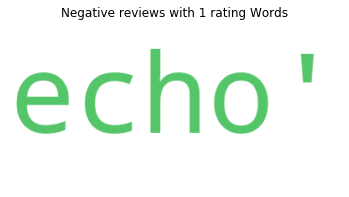

In [41]:
#Generating wordcloud for reviews
if(len(neg_1) > 0):
    negtv_1 = str(neg_1)
    wordCloud = WordCloud(background_color="white").generate(negtv_1)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Negative reviews with 1 rating Words')
    plt.show()

In [43]:
#Generating wordcloud for reviews
if(len(neg_2) > 0):
    negtv_2 = str(neg_2)
    wordCloud = WordCloud(background_color="white").generate(negtv_2)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Negative reviews with 2 rating Words')
    plt.show()

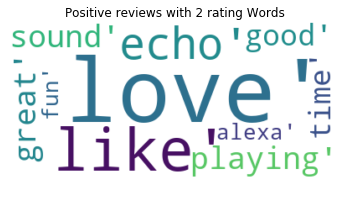

In [44]:
if(len(pos_2) > 0):
    postv_2 = str(pos_2)
    wordCloud = WordCloud(background_color="white").generate(postv_2)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive reviews with 2 rating Words')
    plt.show()

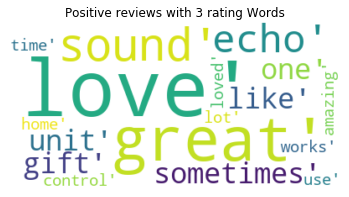

In [45]:
if(len(pos_3) > 0):
    postv_3 = str(pos_3)
    wordCloud = WordCloud(background_color="white").generate(postv_3)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive reviews with 3 rating Words')
    plt.show()

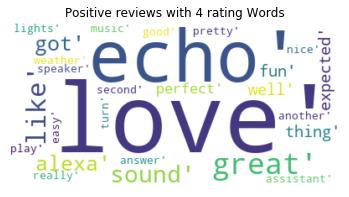

In [46]:
if(len(pos_4) > 0):
    postv_4 = str(pos_4)
    wordCloud = WordCloud(background_color="white").generate(postv_4)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive reviews with 4 rating Words')
    plt.show()

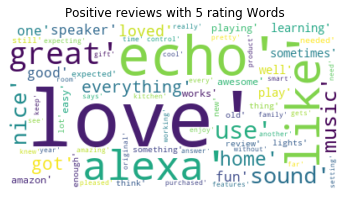

In [47]:
if(len(pos_5) > 0):
    postv_5 = str(pos_5)
    wordCloud = WordCloud(background_color="white").generate(postv_5)
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive reviews with 5 rating Words')
    plt.show()